# Xenium registration (using MERFISH to Visium pipeline)

In [1]:
# Jean's attempt to make minimal viable example
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import tools

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

In [2]:
tools.LDDMM

<function tools.LDDMM(xI, I, xJ, J, pointsI=None, pointsJ=None, L=None, T=None, A=None, v=None, xv=None, a=500.0, p=2.0, expand=2.0, nt=3, niter=5000, diffeo_start=0, epL=2e-08, epT=0.2, epV=2000.0, sigmaM=1.0, sigmaB=2.0, sigmaA=5.0, sigmaR=500000.0, sigmaP=20.0, device='cpu', dtype=torch.float64, muB=None, muA=None)>

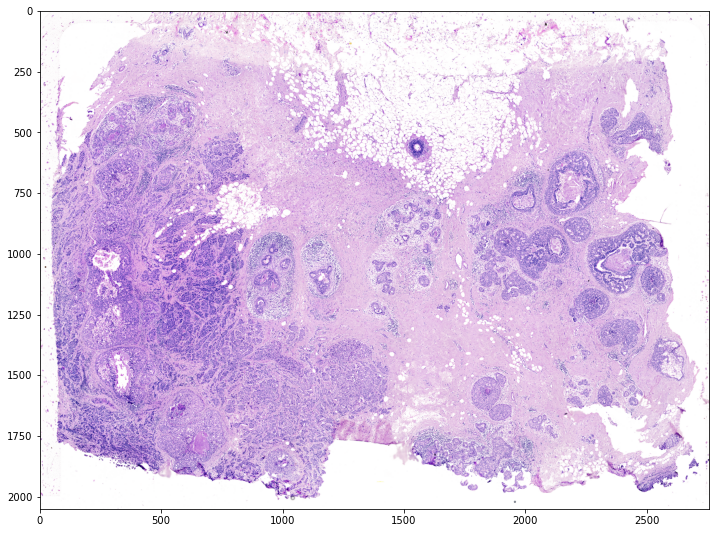

In [3]:
# Target 
# read in single-cell image
image_file = '/Users/jeanfan/Desktop/STalign/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.png'
V = plt.imread(image_file)

# plot
fig,ax = plt.subplots()
ax.imshow(V)

In [4]:
print(V.shape)
I = tools.normalize(V).transpose(2,0,1)
print(I.shape)

YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for tools.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for tools.transform later so multiply by 1.

(2051, 2759, 3)
(3, 2051, 2759)


In [5]:
# Single cell data to be aligned
fname = '/Users/jeanfan/Desktop/STalign/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz'
df = pd.read_csv(fname)
df.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
0,1,377.663005,843.541888,154,0,0,154,110.361875,45.562656
1,2,382.078658,858.944818,64,0,0,64,87.919219,24.248906
2,3,319.839529,869.196542,57,0,0,57,52.561875,23.526406
3,4,259.304707,851.797949,120,0,0,120,75.230312,35.176719
4,5,370.576291,865.193024,120,0,0,120,180.218594,34.499375


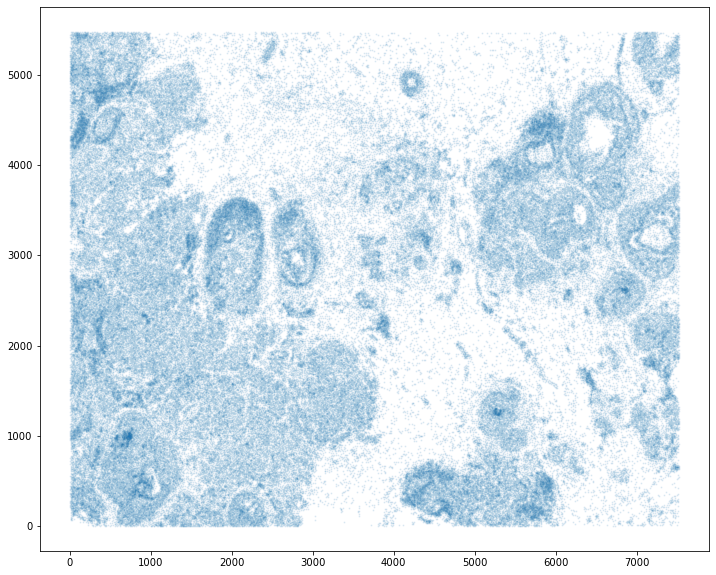

In [6]:
# get cell centroid coordinates
xM = np.array(df['x_centroid'])
yM = np.array(df['y_centroid'])

# plot
fig,ax = plt.subplots()
ax.scatter(xM,yM,s=1,alpha=0.1)

0 of 167782
10000 of 167782
20000 of 167782
30000 of 167782
40000 of 167782
50000 of 167782
60000 of 167782
70000 of 167782
80000 of 167782
90000 of 167782
100000 of 167782
110000 of 167782
120000 of 167782
130000 of 167782
140000 of 167782
150000 of 167782
160000 of 167782
167781 of 167782


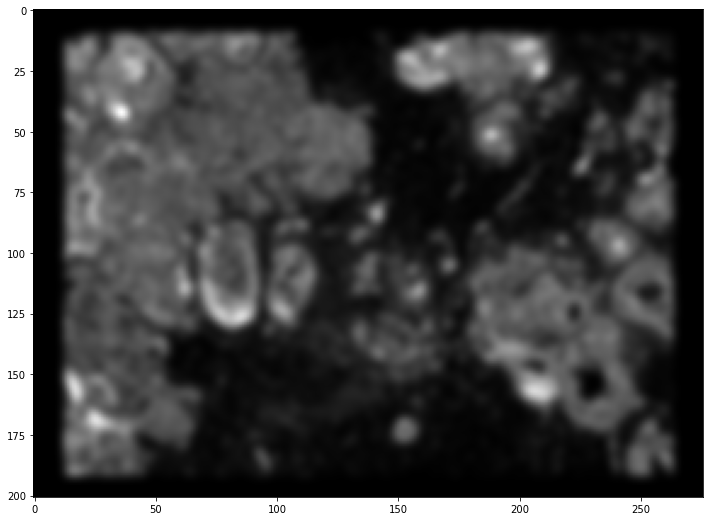

In [7]:
# rasterize at 30um resolution (assuming positions are in um units) and plot
XJ,YJ,M,fig = tools.rasterize(xM,yM,dx=30)
ax = fig.axes[0]

In [16]:
print(M.shape)
J = np.vstack((M, M, M)) # because of invalid shape issue later need
J = tools.normalize(J)
print(J.shape)

(1, 201, 276)
(3, 201, 276)


In [17]:
# double check size of things
print(J.shape)
print(I.shape)

(3, 201, 276)
(3, 2051, 2759)


In [18]:
extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))

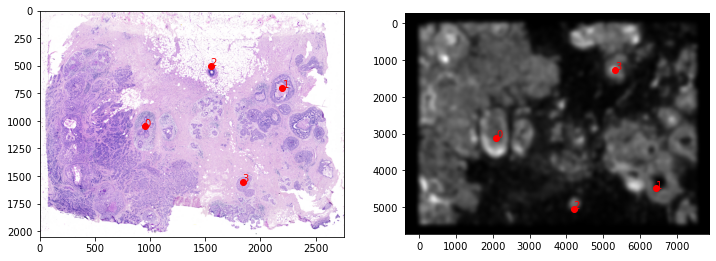

In [19]:
# manually make corresponding points
pointsI = np.array([[1050.,950.], [700., 2200.], [500., 1550.], [1550., 1840.]])
pointsJ = np.array([[1110.,750.], [1600., 2300.], [1800., 1500.], [450., 1900.]]) * 2.8

# plot
fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()), extent=extentI) 
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ) 

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red')
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red')
for i in range(pointsI.shape[0]):
    ax[0].text(pointsI[i,1],pointsI[i,0],f'{i}', c='red')
    ax[1].text(pointsJ[i,1],pointsJ[i,0],f'{i}', c='red')

In [20]:
# compute initial affine transformation from points
L,T = tools.L_T_from_points(pointsI,pointsJ)

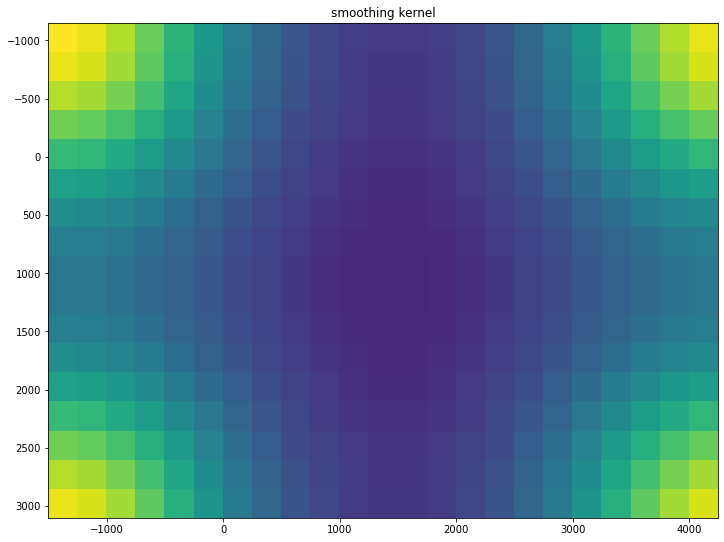

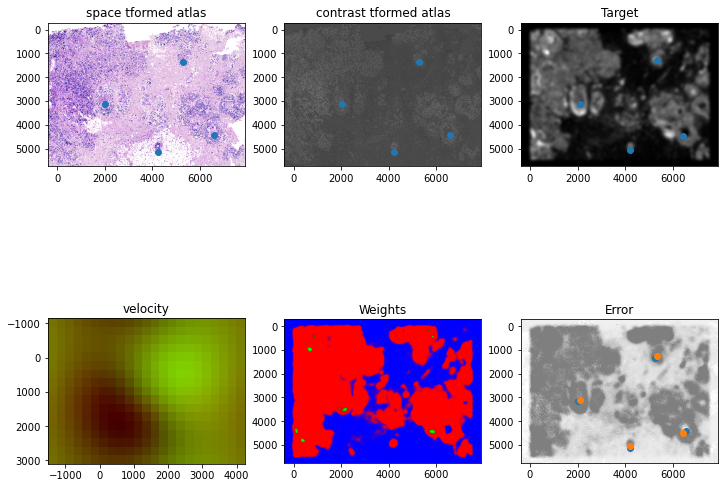

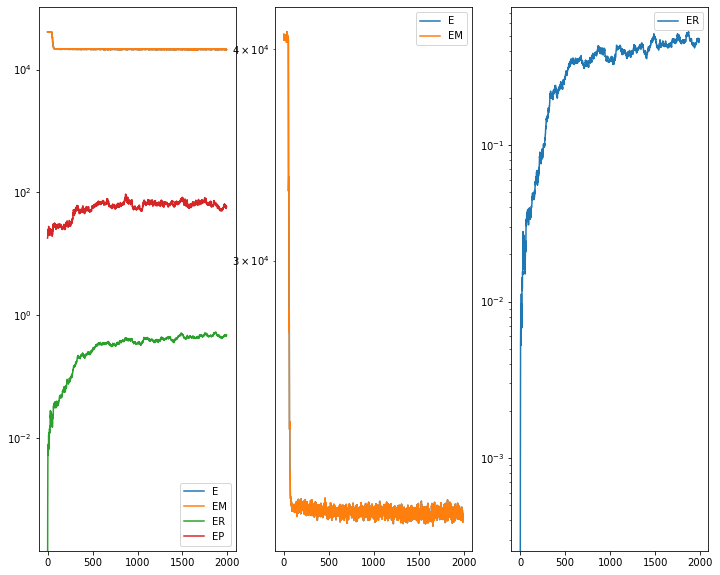

In [45]:
# run LDDMM
# running this on my desktop so cpu device
device = 'cpu' 

# keep all other parameters default
params = {'L':L,'T':T,
          'niter':2000,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'device':device,
          'sigmaM':0.15, # Jean's note: still difficult to intuit these parameters; make histogram to help?
          'sigmaB':0.10,
          'sigmaA':0.11,
          'epV': 10,
          'muB': torch.tensor([0,0,0]), # black is background in target
          'muA': torch.tensor([1,1,1]) # white is artifact 
          }

A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,**params)

In [46]:
# now transform the points 
phi = tools.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = tools.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],J,[YI,XI])
phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,pointsJ)

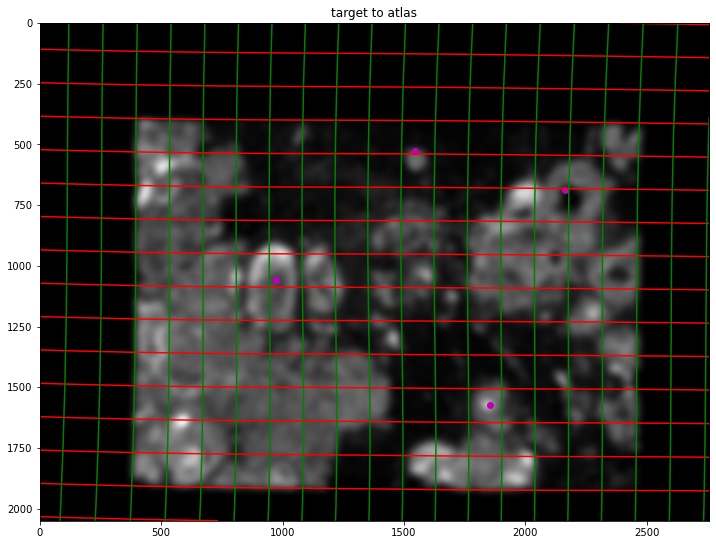

In [47]:
# plot
fig,ax = plt.subplots()

levels = np.arange(-50000,50000,500)

ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to atlas')

ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="m")

In [48]:
# Now apply to points 
tpointsI = tools.transform_points_target_to_atlas(xv,v,A,np.stack([yM, xM], -1))
phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,pointsJ)

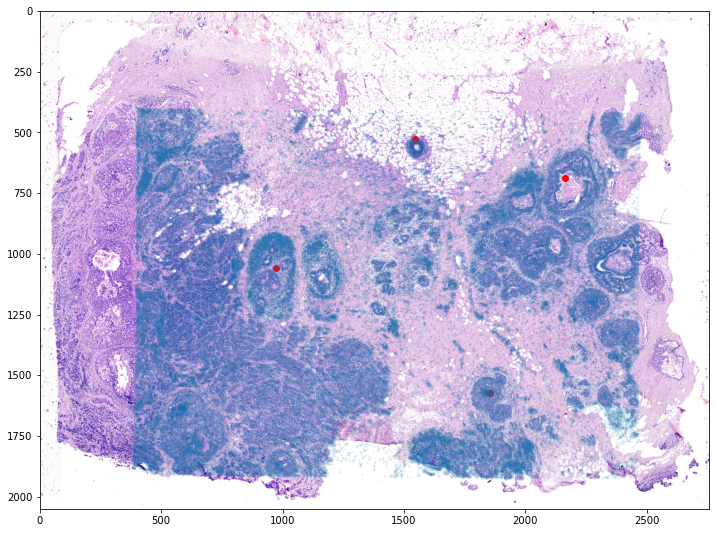

In [49]:
# plot
fig,ax = plt.subplots()
ax.imshow((I).transpose(1,2,0),extent=extentI)
#ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach(),c="r")
ax.scatter(tpointsI[:,1].detach(),tpointsI[:,0].detach(),s=1,alpha=0.1)

In [39]:
# save results by appending
print(df.shape)
print(tpointsI.shape)
print(tpointsI.numpy().shape)

results = np.hstack((df, tpointsI.numpy()))
print(results.shape)

(167782, 9)
torch.Size([167782, 2])
(167782, 2)
(167782, 11)


In [50]:
np.savetxt('sample1_toHE_STalign.csv', results, delimiter=',')